In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
import os

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device available")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA available: True
CUDA version: 12.1
cuDNN version: 8801
Device name: NVIDIA GeForce RTX 3070


In [3]:
transform_train = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.Resize((224, 224)),
  transforms.Pad(4),
  transforms.RandomCrop((224, 224)),
  transforms.RandomRotation(10),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
data_dir = 'Larger'
batch_size = 32
num_workers = 8

full_dataset = datasets.ImageFolder(data_dir, transform=transform_train)
train_size = int(0.7 * len(full_dataset))
remaining_size = len(full_dataset) - train_size
val_size = remaining_size // 2
test_size = remaining_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Update the transforms for validation and test datasets
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [35]:
# Check the distribution of classes in given loader
def calculate_class_image_count_in_loader(loader_name, loader):
    class_counts = {class_name: 0 for class_name in full_dataset.classes}
    for _, labels in loader:
        for label in labels:
            class_counts[full_dataset.classes[label]] += 1

    print(30*'=')
    print(f"Class distribution in {loader_name}_loader:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")

calculate_class_image_count_in_loader('train', train_loader)
calculate_class_image_count_in_loader('val', val_loader)
calculate_class_image_count_in_loader('test', test_loader)

Class distribution in train_loader:
Coccidiosis: 1455
Healthy: 1443
Newcastle: 265
Salmonella: 1605
Class distribution in val_loader:
Coccidiosis: 330
Healthy: 302
Newcastle: 50
Salmonella: 340
Class distribution in test_loader:
Coccidiosis: 318
Healthy: 312
Newcastle: 61
Salmonella: 331


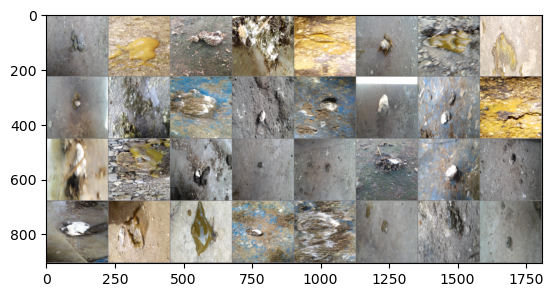

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  # Unnormalize image
  img = img / 2 + 0.5
  # Convert to numpy objects
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# Get random training images with iter function
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))

In [45]:
print(f"Dataset classes: {full_dataset.classes}")
print(f"Item count in dataset: {len(full_dataset)}")

Dataset classes: ['Coccidiosis', 'Healthy', 'Newcastle', 'Salmonella']
Item count in dataset: 6812


In [5]:
model = models.alexnet(pretrained=False)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(full_dataset.classes))
print(model)

c:\Users\Lukas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lukas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\Lukas/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:07<00:00, 34.5MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    # Lists to store loss and accuracy values
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print('-' * 10)
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)

            print(f'{phase} phase - Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}')

            # Save loss and accuracy
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.cpu().numpy())  # Convert to numpy
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.cpu().numpy())  # Convert to numpy

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    print(40*'=')
    print(f'Best validation accuracy: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Plot training and validation loss
    plt.figure(figsize=(12, 5))

    epochs = range(1, num_epochs+1)

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xticks(epochs)  # Set x-ticks to be the epochs
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xticks(epochs)  # Set x-ticks to be the epochs
    plt.legend()

    plt.show()

    return model

### Training data with the bigger dataset

Training with LR=0.001
----------
Epoch 1/10
----------
train phase - Loss: 0.3167 Accuracy: 0.8786
val phase - Loss: 0.1841 Accuracy: 0.9432
----------
Epoch 2/10
----------
train phase - Loss: 0.1457 Accuracy: 0.9451
val phase - Loss: 0.1260 Accuracy: 0.9609
----------
Epoch 3/10
----------
train phase - Loss: 0.0964 Accuracy: 0.9656
val phase - Loss: 0.0806 Accuracy: 0.9726
----------
Epoch 4/10
----------
train phase - Loss: 0.0633 Accuracy: 0.9773
val phase - Loss: 0.0894 Accuracy: 0.9706
----------
Epoch 5/10
----------
train phase - Loss: 0.0482 Accuracy: 0.9826
val phase - Loss: 0.0765 Accuracy: 0.9755
----------
Epoch 6/10
----------
train phase - Loss: 0.0452 Accuracy: 0.9843
val phase - Loss: 0.1116 Accuracy: 0.9648
----------
Epoch 7/10
----------
train phase - Loss: 0.0351 Accuracy: 0.9876
val phase - Loss: 0.0827 Accuracy: 0.9775
----------
Epoch 8/10
----------
train phase - Loss: 0.0182 Accuracy: 0.9935
val phase - Loss: 0.0903 Accuracy: 0.9775
----------
Epoch 9/10
---

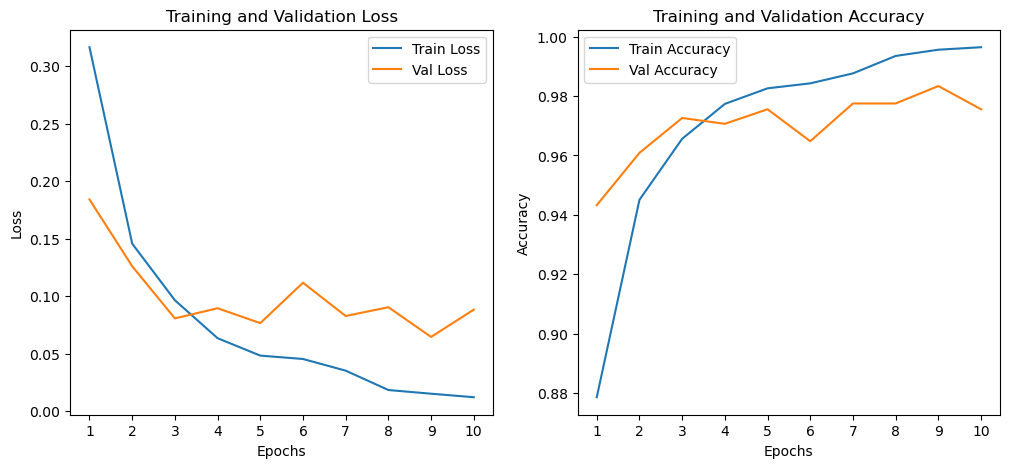

In [7]:
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

model = model.to(device)
print(f"Training with LR={lr}")
model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)

Utility functions for saving and loading model states

In [30]:
torch.save(model.state_dict(), 'poultry_disease_alexnet-larger.pth')

In [18]:
#model.load_state_dict(torch.load('poultry_disease_alexnet-larger.pth', map_location=device))

<All keys matched successfully>

In [37]:
data_dir = 'Smaller'
batch_size = 32
num_workers = 8

full_dataset = datasets.ImageFolder(data_dir, transform=transform_train)
train_size = int(0.7 * len(full_dataset))
remaining_size = len(full_dataset) - train_size
val_size = remaining_size // 2
test_size = remaining_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Update the transforms for validation and test datasets
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [38]:
# Check the distribution of classes in given loader
calculate_class_image_count_in_loader('train', train_loader)
calculate_class_image_count_in_loader('val', val_loader)
calculate_class_image_count_in_loader('test', test_loader)

Class distribution in train_loader:
Coccidiosis: 258
Healthy: 236
Newcastle: 135
Salmonella: 249
Class distribution in val_loader:
Coccidiosis: 57
Healthy: 53
Newcastle: 24
Salmonella: 54
Class distribution in test_loader:
Coccidiosis: 58
Healthy: 58
Newcastle: 27
Salmonella: 46


In [43]:
print(f"Dataset classes: {full_dataset.classes}")
print(f"Item count in dataset: {len(full_dataset)}")

Dataset classes: ['Coccidiosis', 'Healthy', 'Newcastle', 'Salmonella']
Item count in dataset: 1255


Training with LR=0.001
----------
Epoch 1/10
----------


c:\Users\Lukas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lukas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train phase - Loss: 1.0499 Accuracy: 0.5866
val phase - Loss: 0.6728 Accuracy: 0.7606
----------
Epoch 2/10
----------
train phase - Loss: 0.4652 Accuracy: 0.8736
val phase - Loss: 0.4458 Accuracy: 0.8617
----------
Epoch 3/10
----------
train phase - Loss: 0.2558 Accuracy: 0.9374
val phase - Loss: 0.4020 Accuracy: 0.8723
----------
Epoch 4/10
----------
train phase - Loss: 0.1584 Accuracy: 0.9636
val phase - Loss: 0.3885 Accuracy: 0.8723
----------
Epoch 5/10
----------
train phase - Loss: 0.1228 Accuracy: 0.9681
val phase - Loss: 0.3864 Accuracy: 0.8723
----------
Epoch 6/10
----------
train phase - Loss: 0.0979 Accuracy: 0.9784
val phase - Loss: 0.3891 Accuracy: 0.8777
----------
Epoch 7/10
----------
train phase - Loss: 0.0705 Accuracy: 0.9852
val phase - Loss: 0.4014 Accuracy: 0.8830
----------
Epoch 8/10
----------
train phase - Loss: 0.0648 Accuracy: 0.9841
val phase - Loss: 0.4051 Accuracy: 0.8777
----------
Epoch 9/10
----------
train phase - Loss: 0.0520 Accuracy: 0.9841
val 

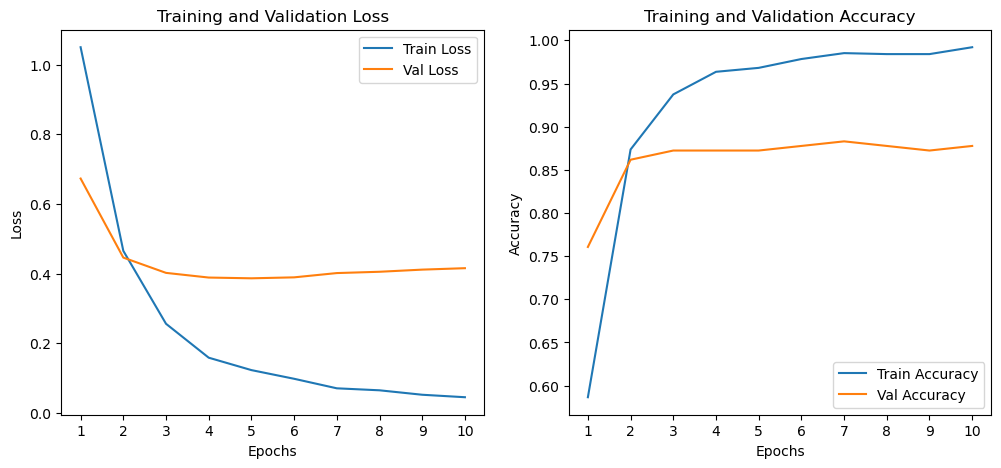

In [40]:
# Reset model and train with smaller dataset
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(full_dataset.classes))

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

model = model.to(device)
print(f"Training with LR={lr}")
model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)

In [41]:
torch.save(model.state_dict(), 'poultry_disease_alexnet-smaller.pth')

In [ ]:
#model.load_state_dict(torch.load('poultry_disease_alexnet-smaller.pth', map_location=device))

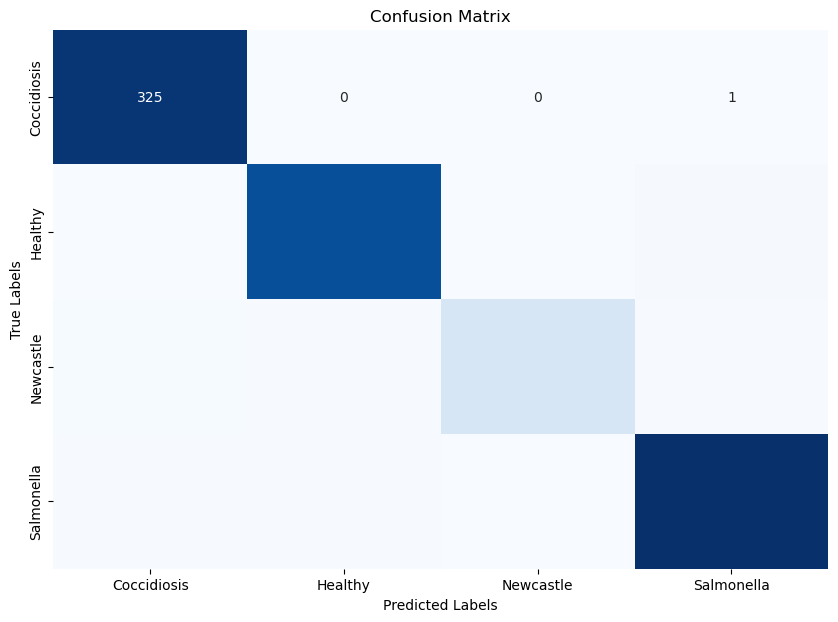

Accuracy: 0.9824
Precision: 0.9824
Recall: 0.9824
F1 Score: 0.9822


In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

true_labels = []
predicted_labels = []

model.eval()
model = model.to(device)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(20*'=')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

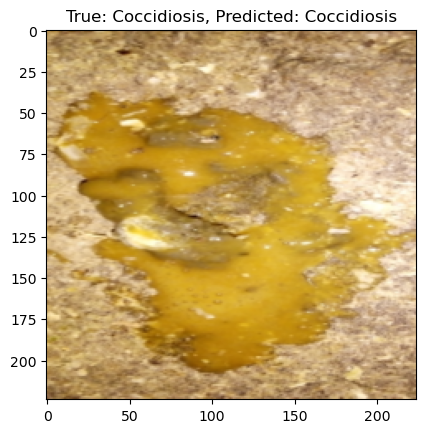

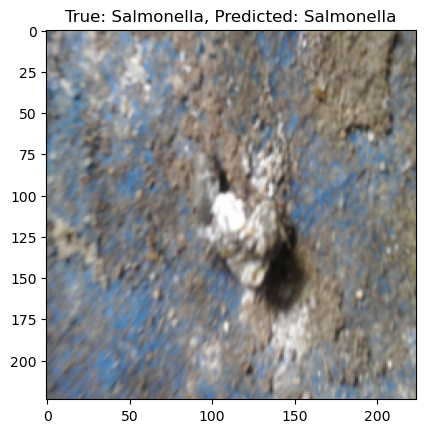

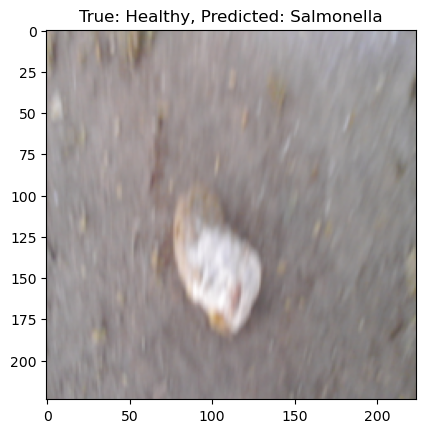

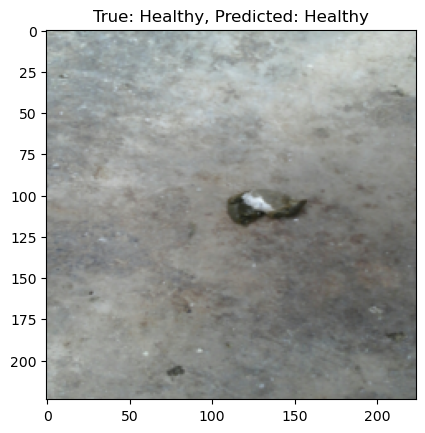

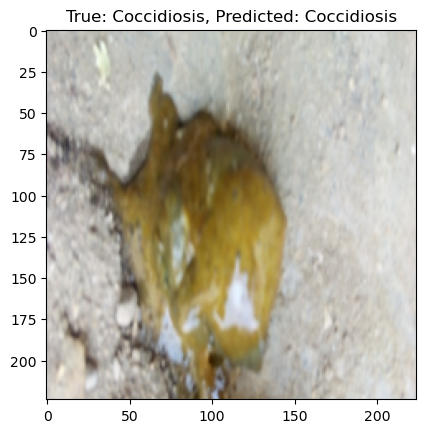

True labels:  ['Coccidiosis', 'Salmonella', 'Healthy', 'Healthy', 'Coccidiosis', 'Healthy', 'Newcastle', 'Coccidiosis', 'Healthy', 'Newcastle', 'Healthy', 'Coccidiosis', 'Healthy', 'Coccidiosis', 'Healthy', 'Salmonella', 'Healthy', 'Newcastle', 'Newcastle', 'Coccidiosis', 'Healthy', 'Coccidiosis', 'Salmonella', 'Coccidiosis', 'Newcastle', 'Coccidiosis', 'Salmonella', 'Salmonella', 'Healthy', 'Salmonella', 'Healthy', 'Coccidiosis']
Predicted labels:  ['Coccidiosis', 'Salmonella', 'Salmonella', 'Healthy', 'Coccidiosis', 'Healthy', 'Newcastle', 'Coccidiosis', 'Healthy', 'Newcastle', 'Healthy', 'Coccidiosis', 'Healthy', 'Coccidiosis', 'Healthy', 'Salmonella', 'Healthy', 'Newcastle', 'Newcastle', 'Coccidiosis', 'Healthy', 'Coccidiosis', 'Salmonella', 'Coccidiosis', 'Newcastle', 'Coccidiosis', 'Salmonella', 'Salmonella', 'Healthy', 'Salmonella', 'Healthy', 'Coccidiosis']


In [21]:
# Get a batch of data from the test_loader
data_iter = iter(test_loader)
images, labels = next(data_iter)

images = images.to(device)
labels = labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Move labels and predictions back to CPU
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Function to show an image
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

# Display a few images with true and predicted labels
number_of_images_to_show = 5
for i in range(min(number_of_images_to_show, len(images))):
    imshow(images[i], title=f"True: {full_dataset.classes[labels[i]]}, Predicted: {full_dataset.classes[predicted[i]]}")

# Print true and predicted labels for a single batch
print("True labels: ", [full_dataset.classes[labels[i]] for i in range(len(labels))])
print("Predicted labels: ", [full_dataset.classes[predicted[i]] for i in range(len(predicted))])